In [45]:
import torch
from torch.utils.data import Dataset
from typing import Tuple
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt


#### LOADING THE MODEL

from torchvision.models import resnet18

model = resnet18(weights=False)
model.fc = torch.nn.Linear(512, 44)

ckpt = torch.load("./01_MIA_67.pt", map_location="cuda:0")

model.load_state_dict(ckpt)

#### DATASETS

class TaskDataset(Dataset):
    def __init__(self, transform=None):

        self.ids = []
        self.imgs = []
        self.labels = []

        self.transform = transform

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if not self.transform is None:
            img = self.transform(img)
        label = self.labels[index]
        return id_, img, label

    def __len__(self):
        return len(self.ids)


class MembershipDataset(TaskDataset):
    def __init__(self, transform=None):
        super().__init__(transform)
        self.membership = []

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int, int]:
        id_, img, label = super().__getitem__(index)
        return id_, img, label, self.membership[index]


#data: MembershipDataset = torch.load("./priv_out.pt")

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
data: MembershipDataset = torch.load("./pub.pt")


In [12]:

confidence_scores_original = []
confidence_scores_prediction = []

label_predicted = []
labels = []

memebership = []    

model.eval()  # put model in evaluation mode

for i in range(len(data)):
    id_, img, label, member_status = data[i]
    img = img.unsqueeze(0)  # add batch dimension
    score = model(img)  # get model's score
    confidence_score = torch.nn.functional.softmax(score, dim=1)
    
    label_pred = torch.argmax(confidence_score).item()
    
    
    confidence_scores_prediction.append(confidence_score[0][label_pred].item())
    confidence_scores_original.append(confidence_score[0][label].item())
    
    
    label_predicted.append(label_pred)
    labels.append(label)
    memebership.append(member_status)

In [26]:
label_predicted,labels,memebership==1

(array([29, 29, 29, ..., 41, 29, 23]),
 array([17, 21, 36, ..., 41, 17,  6]),
 False)

In [27]:
np.array(memebership)==1

array([False,  True,  True, ..., False,  True, False])

In [32]:
# make a df with the results
df = pd.DataFrame(data={"label_predicted": label_predicted, "labels": labels, "memebership": memebership, "confidence_scores_original": confidence_scores_original, "confidence_scores_prediction": confidence_scores_prediction})
# save the df
df.to_csv("results.csv")

In [33]:
df

,label_predicted,labels,memebership,confidence_scores_original,confidence_scores_prediction
0,29,17,0,3.829411e-06,0.994277
1,29,21,1,8.998350e-06,0.999031
2,29,36,1,1.931137e-02,0.969153
3,36,41,0,1.889923e-01,0.617641
4,34,33,0,1.760844e-07,0.918233
...,...,...,...,...,...
19995,29,25,1,1.833001e-05,0.996855
19996,11,40,1,8.281711e-05,0.559023
19997,41,41,0,4.105585e-01,0.410559
19998,29,17,1,3.317131e-05,0.992572


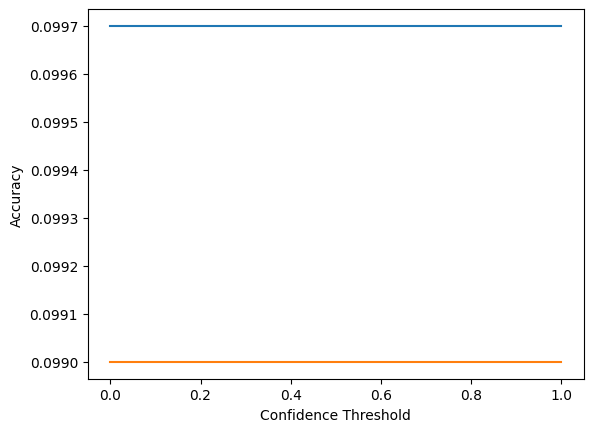

In [35]:

# Assuming `confidence_scores` is a list of confidence scores for each prediction,
# and `labels` is a list of true labels for each data point

# Convert lists to numpy arrays
confidence_scores = np.array(confidence_scores_prediction)
labels = np.array(labels)
label_predicted = np.array(label_predicted)
memebership = np.array(memebership)

# Calculate accuracy at different confidence thresholds
thresholds = np.linspace(0, 1, 100)
accuracies_m = []
accuracies_nm = []
for threshold in thresholds:
    # Get predictions where confidence score is above the threshold
    preds = confidence_scores > threshold
    # Calculate accuracy
    accuracy_members = np.mean((label_predicted == labels)[memebership==1])
    accuracy_nonmembers = np.mean((label_predicted == labels)[memebership==0])
    accuracies_m.append(accuracy_members)
    accuracies_nm.append(accuracy_nonmembers)
    

# Plot accuracy vs confidence threshold
plt.plot(thresholds, accuracies_m)
plt.plot(thresholds, accuracies_nm)
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Find the statistics of how frequent a nodes in the neural network  is activated for a given set of images.

In [58]:
import torch

# Assuming `model` is your trained ResNet model and `data` is your dataset

# Create a dictionary to store the outputs
outputs = {}

# Define a hook function to record the outputs
def hook(module, input, output):
    # Store the output of each module
    if (output > 0).any():
        outputs[str(module)] = output

# Register the hook for each module in the model
for name, module in model.named_modules():
    module.register_forward_hook(hook)

model.eval()
# Run an image through the model and record the outputs
id_, img, label, member_status = data[0]  # using the first image as an example
img = img.unsqueeze(0)  # add batch dimension, if your model expects it
score = model(img)  # get model's score

# Now `outputs` is a dictionary where the keys are the names of the modules in the model
# and the values are the outputs of each module

In [59]:
for i in outputs.values():
    print(i.shape)

torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 8, 8])
torch.Size([1, 512, 1, 1])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 128, 4, 4])
torch.Size([1, 128, 4, 4])
torch.Size([1, 128, 4, 4])
torch.Size([1, 128, 4, 4])
torch.Size([1, 128, 4, 4])
torch.Size([1, 128, 4, 4])
torch.Size([1, 128, 4, 4])
torch.Size([1, 128, 4, 4])
torch.Size([1, 256, 2, 2])
torch.Size([1, 256, 2, 2])
torch.Size([1, 256, 2, 2])
torch.Size([1, 256, 2, 2])
torch.Size([1, 256, 2, 2])
torch.Size([1, 256, 2, 2])
torch.Size([1, 256, 2, 2])
torch.Size([1, 256, 2, 2])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 44])
torch.Size([1, 44])


In [61]:
# Assuming `data` is your original dataset

# Separate the data into two datasets based on the membership flag
data1 = [item for item in data if item[3] == 1]  # membership is 1
data2 = [item for item in data if item[3] == 0]  # membership is 0

# The rest of the code remains the same

In [65]:
import torch

# Assuming `model` is your trained ResNet model and `data1` and `data2` are your datasets

# Create a dictionary to store the outputs
outputs1 = {}
outputs2 = {}

# Define a hook function to record the outputs
def hook1(module, input, output):
    if str(module) not in outputs1:
        outputs1[str(module)] = output.detach()
    else:
        outputs1[str(module)] += output.detach()

def hook2(module, input, output):
    if str(module) not in outputs2:
        outputs2[str(module)] = output.detach()
    else:
        outputs2[str(module)] += output.detach()

# Register the hook for each module in the model
for name, module in model.named_modules():
    module.register_forward_hook(hook1)

# Run the first dataset through the model and record the outputs
for i in range(len(data1)):
    id_, img, label, member_status = data1[i]
    img = img.unsqueeze(0)  # add batch dimension, if your model expects it
    score = model(img)  # get model's score

# Register the hook for each module in the model
for name, module in model.named_modules():
    module.register_forward_hook(hook2)

# Run the second dataset through the model and record the outputs
for i in range(len(data2)):
    id_, img, label, member_status = data2[i]
    img = img.unsqueeze(0)  # add batch dimension, if your model expects it
    score = model(img)  # get model's score

# Now `outputs1` and `outputs2` are dictionaries where the keys are the names of the modules in the model
# and the values are the outputs of each module for the first and second dataset, respectively

# Calculate the average output for each module
for module in outputs1.keys():
    outputs1[module] /= len(data1)

for module in outputs2.keys():
    outputs2[module] /= len(data2)


In [70]:
# Compare the outputs to find differentially expressed nodes
# For example, you can use a t-test to compare the means of the outputs
from scipy.stats import ttest_ind

for module in outputs1.keys():
    output1 = outputs1[module].detach().numpy().flatten()
    output2 = outputs2[module].detach().numpy().flatten()
    t_stat, p_val = ttest_ind(output1, output2)
    print(output2==output1)
    if p_val < 0.9:
        print(f"{module} is differentially expressed")

[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  Tr

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_stats_py.py:1088: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2


In [71]:
output1

array([-1.68020492e+21, -1.48304985e+21, -1.27003001e+21, -1.48804040e+21,
       -1.45327318e+21,  7.01796563e+20, -1.08912105e+21, -1.22357313e+21,
       -1.26871862e+21, -1.55413763e+21,  1.06037412e+20, -8.44010986e+19,
       -2.26487250e+21, -3.30240714e+19, -5.73946864e+20, -1.50921084e+21,
       -6.63400632e+20, -1.30215757e+21, -1.27848468e+21, -7.89705491e+20,
       -6.55644237e+20, -2.33034442e+21, -1.59635592e+21, -1.27228139e+21,
       -4.73492773e+20, -1.21143579e+21, -4.88741398e+20, -1.20397023e+21,
       -6.62688571e+20,  1.20946786e+21, -3.00121371e+21,  8.18355703e+20,
       -1.38771597e+21, -1.02203458e+21, -8.73412490e+20, -5.85041024e+20,
       -1.08890199e+21, -2.39911344e+20, -1.02478994e+21, -9.53912644e+20,
       -4.39335714e+20, -1.64969683e+21, -1.55897914e+21, -2.30722744e+21],
      dtype=float32)

In [72]:
output2

array([-1.68020492e+21, -1.48304985e+21, -1.27003001e+21, -1.48804040e+21,
       -1.45327318e+21,  7.01796563e+20, -1.08912105e+21, -1.22357313e+21,
       -1.26871862e+21, -1.55413763e+21,  1.06037412e+20, -8.44010986e+19,
       -2.26487250e+21, -3.30240714e+19, -5.73946864e+20, -1.50921084e+21,
       -6.63400632e+20, -1.30215757e+21, -1.27848468e+21, -7.89705491e+20,
       -6.55644237e+20, -2.33034442e+21, -1.59635592e+21, -1.27228139e+21,
       -4.73492773e+20, -1.21143579e+21, -4.88741398e+20, -1.20397023e+21,
       -6.62688571e+20,  1.20946786e+21, -3.00121371e+21,  8.18355703e+20,
       -1.38771597e+21, -1.02203458e+21, -8.73412490e+20, -5.85041024e+20,
       -1.08890199e+21, -2.39911344e+20, -1.02478994e+21, -9.53912644e+20,
       -4.39335714e+20, -1.64969683e+21, -1.55897914e+21, -2.30722744e+21],
      dtype=float32)